(95, 91)


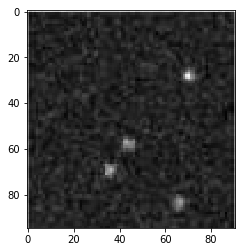

In [1]:
%matplotlib inline
import numpy as np
import os, string
from matplotlib import pyplot as plt
import scipy as sp
import cv2
import tensorflow as tf
import sys,time,tifffile
img = cv2.imread('data.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(img.shape)
plt.imshow(img,cmap='gray')

In [2]:
mu = 2
sigma = 1.
kernel = np.zeros((1,5))
for i in range(1,4):
    kernel[0,i] = np.exp( -(i - mu) ** 2 / (2. * sigma **2) )
kernel /= np.sum(kernel)
kernel[0,0]=kernel[0,4]=-2
kernel[0,1:4] *= 4
kernel = np.round(kernel)
print(kernel,kernel.sum())

[[-2.  1.  2.  1. -2.]] 0.0


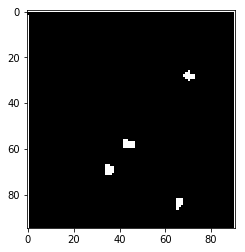

In [3]:
#res1 = cv2.filter2D(img, -1,kernel = kernel)
#res2 = cv2.filter2D(img, -1,kernel = kernel.transpose())
res = img
for i in range(20):
    res = cv2.blur(res,ksize=(3,3))

binImg = img > res + 6. *np.sqrt(res)
plt.imshow(binImg,cmap='gray')

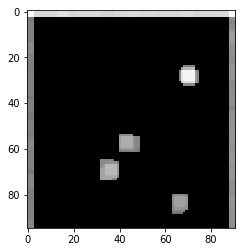

In [4]:
with tf.device('/cpu:0'):
    O = tf.placeholder('float', shape=[1,95,91,1])
    B = tf.nn.max_pool(O, ksize=[1,5,5,1],padding='SAME',strides=[1,1,1,1])

sess = tf.Session()
sess.run(tf.global_variables_initializer())
maskImg = np.multiply(binImg, img)
maxImg = sess.run(B,feed_dict={O:maskImg.reshape([1,95,91,1])})
sess.close()
plt.imshow(maxImg.reshape([95,91]), cmap='gray')

226


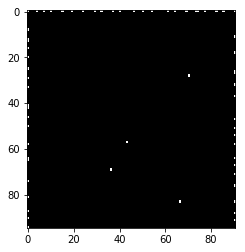

In [5]:
mImg = np.int32(maxImg.reshape([95,91]))
print(mImg.max())
ptImg = np.zeros_like(img)
ptImg[(mImg == img) ]=255
plt.imshow(ptImg, cmap='gray')

In [9]:
ptImg[:5,:] = ptImg[:,:5] = ptImg[-5:,:]=ptImg[:,-5:] = 0
pt = np.where(ptImg!=0)
print(pt)
pt0 = [pt[0][0],pt[1][0]]
print(pt0)
#subimg = img[pt[0][0]]

(array([28, 57, 69, 83]), array([70, 43, 36, 66]))
[28, 70]


(10, 10)


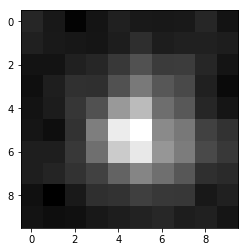

In [24]:
subimg = img[pt0[0] - 5:pt0[0]+5,pt0[1] - 5:pt0[1]+5]
plt.imshow(subimg,cmap='gray')
print(subimg.shape)

In [112]:
with tf.device('/cpu:0'):
    q = tf.placeholder('float',shape=[100,1])
    O = tf.placeholder('float',shape=[100,2])
    xy = tf.Variable([5.,5.])#xy tf.random_uniform([1,2])
    xy = tf.maximum(xy,0)
    sigma = tf.Variable([5.])
    sigma = tf.maximum(sigma,0.01)
    A = tf.Variable([0.5])#peak value
    A = tf.maximum(A,0)
    B = tf.Variable(0.3)#peak value
    B = tf.maximum(B,0)
    I = A * tf.exp(-tf.reduce_sum(tf.square(O-xy),1) / (2. * tf.square(sigma )))+B
    I = tf.reshape(I, [-1,1])
    #print(I.get_shape())
    sumV = tf.reduce_sum(I)
    en = tf.multiply(q,tf.log(I))
    #print(q.get_shape(),tf.log(I).get_shape(),en.get_shape())
    loss =  sumV- tf.reduce_sum(en)
    train_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
tPos = np.zeros([pt[0].shape[0],2])
for k in range(pt[0].shape[0]):
    print(k)
    subimg = img[pt[0][k] - 5:pt[0][k]+5,pt[1][k] - 5:pt[1][k]+5]
    allPt = np.zeros((100,2))
    value = np.zeros((100,1))
    ind = 0
    for i in range(10):
        for j in range(10):
            allPt[ind,:] = [i,j]
            value[ind,0] = subimg[i,j] / 255.
            ind +=1
    #print(value)
    pos=[]
    for i in range(50):
        _,l,pos,s,tu = sess.run([train_op,loss,xy,sigma,I],feed_dict={q:value,O:allPt})#,A,sigma,B,I ,v,s,b,tu
        #if i % 20 == 0:
        #    print(l,pos,s)#,v,s,b
    tPos[k,:] =pos.copy()
    tPos[k,:] += [pt[0][k]-5, pt[1][k]-5]
    
sess.close()
    #plt.imshow(tu.reshape([10,10])*255,cmap='gray')

0
1
2
3


[[ 28.08173466  70.11738205]
 [ 57.32719707  43.15169144]
 [ 69.30591059  35.95719767]
 [ 83.29774666  65.82848835]]


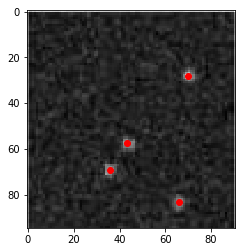

In [113]:
print(tPos)
plt.imshow(img,cmap='gray')
plt.plot(tPos[:,1],tPos[:,0], 'ro')